In [1]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import copy

In [2]:
# equivalent of np.random.choice with numba support
@jit(nopython=True)
def rand_choice_nb(k, prob):
    return np.arange(k)[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

In [3]:
# Gaussian noise generator
@jit(nopython=True)
def gaussian_noise_generator(seed_id, k, steps):
    for i in range(steps):
        np.random.seed(i + seed_id)
        yield np.random.normal(0, 0.01, k)

In [4]:
@jit(nopython=True)
def gradient_bandit(k, env, alpha1, alpha2, seed_id, steps=1000):
    '''
    params
    k: num of arms
    env: the environment represented as a tuple: (mean, cov), mean and cov are both k*1 vectors
    alpha1: step size for updating H(a)
    alpha2: step size for computing average reward R_bar
    seed_id: random seed id used to perturb the environment
    steps: the number of total time steps in a simulation
    '''
    
    # nonstaionary environment setup
    mean, cov = env
    gaus_gen = gaussian_noise_generator(seed_id, k, steps)
    
    # gradient bandit params initialization
    H = np.zeros(k)
    R_bar = 0
    Pi = np.exp(H) / np.sum(np.exp(H))
    
    # avg reward per timestep
    Rt = np.zeros(steps)
    
    # sum of rewards
    R_sum = 0
    
    # percentages of optimal actions at each time step
    opt_act = np.zeros(steps)
    
    # total number of optimal actions
    opt_act_sum = 0
    
    for t, noise in zip(range(1, steps+1), gaus_gen):
        # select an action
        a = rand_choice_nb(k, Pi)
        
        # if an action is optimal action, increment optimal action counter
        if mean[a] == np.max(mean):
            opt_act_sum += 1
        opt_act[t-1] = opt_act_sum / t
        
        # draw a reward from environment
        R = np.random.normal(mean[a], cov[a])
        #print(R)
        
        #R_sum += R
        #Rt[t-1] = R_sum / t
        Rt[t-1] = R
        
        # update H(a)
        for j in range(k):
            if j != a:
                H[j] -= alpha1 * (R - R_bar) * Pi[j]
        H[a] += alpha1 * (R - R_bar) * (1 - Pi[a])
        
        # update softmax distribution Pi
        Pi = np.exp(H) / np.sum(np.exp(H))
        
        # update average reward R_bar
        R_bar += alpha2 * (R - R_bar)
        
        # perturb the environment using random seed
        mean += noise
        #print(noise)
            
    return Rt, opt_act

In [5]:
@jit(nopython=True)
def ucb_bandit(k, C, alpha, env, seed_id, steps=1000):
    '''
    params
    k: number of arms
    C: UCB param
    alpha: step size for updating Q (weighted average)
    env: the environment represented as a tuple: (mean, cov), mean and cov are both k*1 vectors
    seed_id: random seed id used to perturb the environment
    steps: the number of total time steps in a simulation
    '''
    
    # environment setup
    mean, cov = env
    gaus_gen = gaussian_noise_generator(seed_id, k, steps)
    
    # params initializations
    Q = np.zeros(k)
    N = np.zeros(k)
    
    # average reward at each time step
    Rt = np.zeros(steps)
    
    # sum of reward at each time step
    R_sum = 0
    
    # percentages of optimal actions at each time step
    Opt = np.zeros(steps)
    
    # amount of optimal actions at each time step
    Opt_sum = 0
    
    for t, noise in zip(range(1, steps+1), gaus_gen):
        # Upper-confidence bound action selection
        a = Q + C * np.sqrt(np.log(t) / (N + 1e-16))
        max_actions = np.argwhere(a == np.max(a))
        At = max_actions[np.random.randint(0, len(max_actions))][0]
        
        # collect reward from the environment
        R = np.random.normal(mean[At], cov[At])
        #print(R)
        
        # record avg reward and percentage of optimal actions
        #R_sum += R
        #Rt[t-1] = R_sum / t
        Rt[t-1] = R
        
        if mean[At] == np.max(mean):
            Opt_sum += 1
        Opt[t-1] = Opt_sum / t
        
        # update estimates and counts
        N[At] += 1
        Q[At] += alpha * (R - Q[At])
        
        # perturb the environment using noise from noise generator
        mean += noise
        #print(noise)
        
    return Rt, Opt

In [6]:
@jit(nopython=True)
def epsilon_greedy(k, epsilon, alpha, env, seed_id, steps=1000):
    '''
    params
    k: num of arms
    epsilon: greedy params
    alpha: step size for updating Q (weighted average)
    env: the environment represented as a tuple: (mean, cov), mean and cov are both k*1 vectors
    seed_id: random seed id used to perturb the environment
    steps: the number of total time steps in a simulation
    '''
    # setup the environment
    mean, cov = env
    
    gaus_gen = gaussian_noise_generator(seed_id, k, steps)
    
    # params initializations
    Q = np.zeros(k)
    N = np.zeros(k)
    
    # avg reward each timestep
    Rt = np.zeros(steps)
    
    # reward sum at each timestep
    R_sum = 0
    
    # percentage of optimal actions each timestep
    Opt = np.zeros(steps)
    
    # amount of optimal actions at each timestep
    Opt_sum = 0
    
    for t, noise in zip(range(1, steps+1), gaus_gen):
        # epsilon greedy action selection
        rand = np.random.rand()
        if rand > epsilon:
            max_actions = np.argwhere(Q == np.max(Q))
            A = max_actions[np.random.randint(0, len(max_actions))][0]
        else:
            A = np.random.randint(0, k)
        
        # collect reward from environment
        R = np.random.normal(mean[A], cov[A])
        
        # update reward sum and avg reward each timestep
        #R_sum += R
        #Rt[t-1] = R_sum / t
        Rt[t-1] = R
        
        # update total optimal actions and percentages of optimal actions
        if mean[A] == np.max(mean):
            Opt_sum += 1
        Opt[t-1] = Opt_sum / t
        
        # update estimate Q and increment the count
        N[A] += 1
        Q[A] += alpha * (R - Q[A])
        
        # perturb the environment using noise from generator
        mean += noise
        #print(noise)
        
    return Rt, Opt

In [7]:
k = 10
seed_id = 0
steps = 10000
epochs = 200
original_state = np.random.get_state()
np.random.seed(seed_id)
env = (np.random.uniform(-2, 10, k), np.ones(k))
np.random.set_state(original_state)

In [8]:
epsilons = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]
epsilon_avg = []
epsilon_opt = []

for epsilon in epsilons:
    Rt = np.zeros(steps)
    Opt = np.zeros(steps)
    for i in range(epochs):
        rt, opt = epsilon_greedy(k, epsilon, 0.1, copy.deepcopy(env), i, steps)
        Rt += rt
        Opt += opt
    Rt /= epochs
    Opt /= epochs
    epsilon_avg.append(np.sum(Rt[steps//2:]) / (steps/2))
    epsilon_opt.append(np.sum(Opt[steps//2:]) / (steps/2))

C = [1/16, 1/8, 1/4, 1/2, 1, 2, 4]
ucb_avg = []
ucb_opt = []

for c in C:
    Rt = np.zeros(steps)
    Opt = np.zeros(steps)
    for i in range(epochs):
        rt, opt = ucb_bandit(k, c, 0.1, copy.deepcopy(env), i, steps)
        Rt += rt
        Opt += opt
    Rt /= epochs
    Opt /= epochs
    ucb_avg.append(np.sum(Rt[steps//2:]) / (steps/2))
    ucb_opt.append(np.sum(Opt[steps//2:]) / (steps/2))

alphas = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2]
gradient_avg = []
gradient_opt = []

for alpha in alphas:
    Rt = np.zeros(steps)
    Opt = np.zeros(steps)
    for i in range(epochs):
        rt, opt = gradient_bandit(k, copy.deepcopy(env), alpha, 0.1, i, steps)
        Rt += rt
        Opt += opt
        #print(opt)
    Rt /= epochs
    Opt /= epochs
    gradient_avg.append(np.sum(Rt[steps//2:]) / (steps/2))
    gradient_opt.append(np.sum(Opt[steps//2:]) / (steps/2))

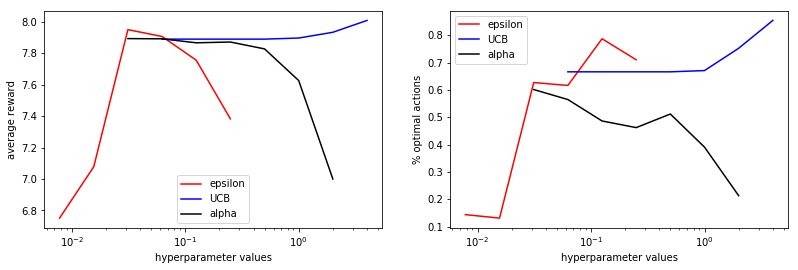

In [9]:
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(121)
ax.plot(epsilons, epsilon_avg, "r")
ax.plot(C, ucb_avg, "b")
ax.plot(alphas, gradient_avg, "black")
ax.set_xscale('log')
plt.legend(["epsilon", "UCB", "alpha"])
plt.ylabel("average reward")
plt.xlabel("hyperparameter values")

ax = fig.add_subplot(122)
ax.plot(epsilons, epsilon_opt, "r")
ax.plot(C, ucb_opt, "b")
ax.plot(alphas, gradient_opt, "black")
ax.set_xscale('log')
plt.legend(["epsilon", "UCB", "alpha"])
plt.ylabel("% optimal actions")
plt.xlabel("hyperparameter values")
plt.show()